# Rat Detection Model Training - YOLOv8\n## For Twilio Integration & Real-time Detection\n\nThis notebook trains a YOLOv8 model to detect and classify:\n- **Norway Rats** (Rattus norvegicus) - Class 0\n- **Roof Rats** (Rattus rattus) - Class 1\n\nDataset: 2,109 images (1,476 train / 421 valid / 212 test)

## 1. Install Dependencies

In [ ]:
# Install required packages\n
!pip install ultralytics opencv-python-headless matplotlib pillow pandas seaborn tqdm pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import yaml
import json
from tqdm import tqdm
from google.colab import drive
from google.colab import files
import zipfile
from datetime import datetime
from ultralytics import YOLO

print("All packages imported successfully!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
All packages imported successfully!


## 2. Verify Dataset and Create data.yaml

In [ ]:
# Define paths - UPDATE THIS PATH to match your dataset location
DRIVE_DATASET_PATH = '/content/drive/MyDrive/zakaria/Rodent_ai_vision/dataset/rodent_yolo_dataset'  # Upload the clean dataset from your local machine
LOCAL_DATASET_PATH = '/content/dataset'

# Check if dataset exists in Drive
if os.path.exists(DRIVE_DATASET_PATH):
    print(f"Dataset found at: {DRIVE_DATASET_PATH}")
    # List contents
    print("\nDataset contents:")
    for item in os.listdir(DRIVE_DATASET_PATH):
        print(f"  - {item}")
else:
    print(f"Dataset not found at: {DRIVE_DATASET_PATH}")
    print("\n⚠️ IMPORTANT: Please upload the dataset to Google Drive first!")
    print("━" * 60)
    print("Steps to upload dataset:")
    print("1. Download the dataset from your local machine:")
    print("   Location: /Users/zakariamasoodgosign/Documents/zakaria/Freelance/RAT_Project/rodent_yolo_dataset")
    print("2. Upload the entire 'rodent_yolo_dataset' folder to your Google Drive")
    print("3. Re-run this cell after upload")
    print("━" * 60)
    print("\nDataset Info:")
    print("- 1,756 unique images (405 norway rats, 1,351 roof rats)")
    print("- Already split into train/valid/test")
    print("- YOLO format annotations included")
    print("- Duplicates already removed")

Dataset found at: /content/drive/MyDrive/zakaria/Rodent_ai_vision/dataset/rodent_yolo_dataset

Dataset contents:
  - data.yaml
  - valid
  - test
  - train


In [ ]:
# Copy dataset to local for faster processing
if os.path.exists(DRIVE_DATASET_PATH):
    print("Copying dataset to local storage...")
    if os.path.exists(LOCAL_DATASET_PATH):
        shutil.rmtree(LOCAL_DATASET_PATH)
    shutil.copytree(DRIVE_DATASET_PATH, LOCAL_DATASET_PATH)
    print("Dataset copied successfully!")

    # Check dataset structure
    print("\nDataset structure:")
    for root, dirs, files in os.walk(LOCAL_DATASET_PATH):
        level = root.replace(LOCAL_DATASET_PATH, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files) - 5} more files")

Copying dataset to local storage...
Dataset copied successfully!

Dataset structure:
dataset/
  data.yaml
  test/
    images/
      roof_591.jpg
      roof_975.jpg
      roof_919.jpg
      norway_032.jpg
      roof_937.jpg
      ... and 207 more files
    labels/
      norway_008.txt
      roof_1049.txt
      norway_159.txt
      norway_501.txt
      norway_259.txt
      ... and 207 more files
  train/
    images/
      roof_004.jpg
      norway_521.jpg
      norway_275.jpg
      roof_1050.jpg
      roof_221.jpg
      ... and 1471 more files
    labels/
      roof_968.txt
      roof_159.txt
      norway_753.txt
      roof_890.txt
      norway_884.txt
      ... and 1471 more files
  valid/
    images/
      norway_928.jpg
      norway_548.jpg
      norway_861.jpg
      roof_774.jpg
      norway_687.jpg
      ... and 416 more files
    labels/
      norway_293.txt
      norway_574.txt
      norway_523.txt
      norway_843.txt
      roof_079.txt
      ... and 416 more files


## 3. Configure Training Parameters

In [ ]:
dataset_path = '/content/dataset'
data_yaml_path = '/content/dataset/data.yaml'
# Training configuration optimized for your dataset\n
training_config = {
    'data': data_yaml_path,
    'epochs': 200,  # Increase if you want better accuracy
    'imgsz': 640,   # Image size
    'batch': 8,    # Adjust based on GPU memory (reduce if OOM)
    'patience': 50, # Early stopping patience
    'save': True,
    'device': 0,    # Use GPU (change to 'cpu' if no GPU)
    'workers': 8,
    'project': 'rat_detection',
    'name': 'yolov8m_rats',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'SGD',
    'verbose': True,
    'seed': 42,
    'deterministic': True,
    'cos_lr': True,
    'close_mosaic': 10,
    'amp': True,  # Mixed precision training
    'lr0': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3.0,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'val': True,
    # Augmentations
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 10,
    'translate': 0.1,
    'scale': 0.5,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.2
}

print("Training configuration set!")
print(f"Key parameters:")
print(f"  - Model: YOLOv8m (medium)")
print(f"  - Epochs: {training_config['epochs']}")
print(f"  - Batch size: {training_config['batch']}")
print(f"  - Image size: {training_config['imgsz']}")
print(f"  - Device: {'GPU' if training_config['device'] == 0 else 'CPU'}")

Training configuration set!
Key parameters:
  - Model: YOLOv8m (medium)
  - Epochs: 200
  - Batch size: 8
  - Image size: 640
  - Device: GPU


### 4. Train the Model

In [ ]:
# Initialize and train the model
model = YOLO('yolov8m.pt')  # Medium model for balance

print("Starting training...")
print("This will take approximately 30-60 minutes on GPU")
print("-" * 50)

try:
    # Train the model
    results = model.train(**training_config)

    print("✅ Training completed successfully!")

except Exception as e:
    print(f"❌ Error during training: {e}")
    print("Troubleshooting:")
    print("1. If OOM error: reduce batch size to 8 or 4")
    print("2. If no GPU: set device='cpu' (will be much slower)")
    print("3. Try using a smaller model: YOLO('yolov8s.pt')")

Starting training...
This will take approximately 30-60 minutes on GPU
--------------------------------------------------
Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/dataset/data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_rats, nbs=64, nm

## 5. Evaluate Model Performance

In [ ]:
# Validate the model
print("Evaluating model performance...")
metrics = model.val()

print("📊 VALIDATION METRICS:")
print("=" * 50)

if metrics:
    print(f"Overall Performance:")
    print(f"  mAP@0.5: {metrics.box.map50:.4f}")
    print(f"  mAP@0.5:0.95: {metrics.box.map:.4f}")
    print(f"  Precision: {metrics.box.mp:.4f}")
    print(f"  Recall: {metrics.box.mr:.4f}")

    # Check if model is good enough
    if metrics.box.map50 > 0.7:
        print("✅ Model performance is GOOD (mAP > 0.7)")
        print("   Ready for deployment!")
    elif metrics.box.map50 > 0.5:
        print("⚠️ Model performance is ACCEPTABLE (mAP > 0.5)")
        print("   Consider training for more epochs")
    else:
        print("❌ Model performance needs improvement (mAP < 0.5)")
        print("   Try: more epochs, different augmentations, or more data")

Evaluating model performance...
Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1580.6±291.6 MB/s, size: 53.6 KB)
val: Scanning /content/dataset/valid/labels.cache... 421 images, 5 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 421/421 1.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 53/53 4.6it/s 11.5s
                   all        421        613      0.426      0.668       0.46      0.366
            norway_rat        263        410      0.616      0.885      0.771      0.669
              roof_rat        153        203      0.237      0.451       0.15     0.0624
Speed: 0.4ms preprocess, 23.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/rat_detection/yolov8m_rats
📊 VALIDATION METRICS:
Overall Performance:
  mAP@0.5: 0.4

## 6. Test Model on Sample Images

✅ Best model loaded

image 1/1 /content/dataset/test/images/roof_591.jpg: 640x640 1 norway_rat, 37.0ms
Speed: 1.6ms preprocess, 37.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/dataset/test/images/roof_975.jpg: 640x640 1 norway_rat, 35.4ms
Speed: 1.8ms preprocess, 35.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/dataset/test/images/roof_919.jpg: 640x640 1 norway_rat, 35.3ms
Speed: 1.6ms preprocess, 35.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/dataset/test/images/norway_032.jpg: 640x640 1 norway_rat, 1 roof_rat, 35.3ms
Speed: 1.4ms preprocess, 35.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


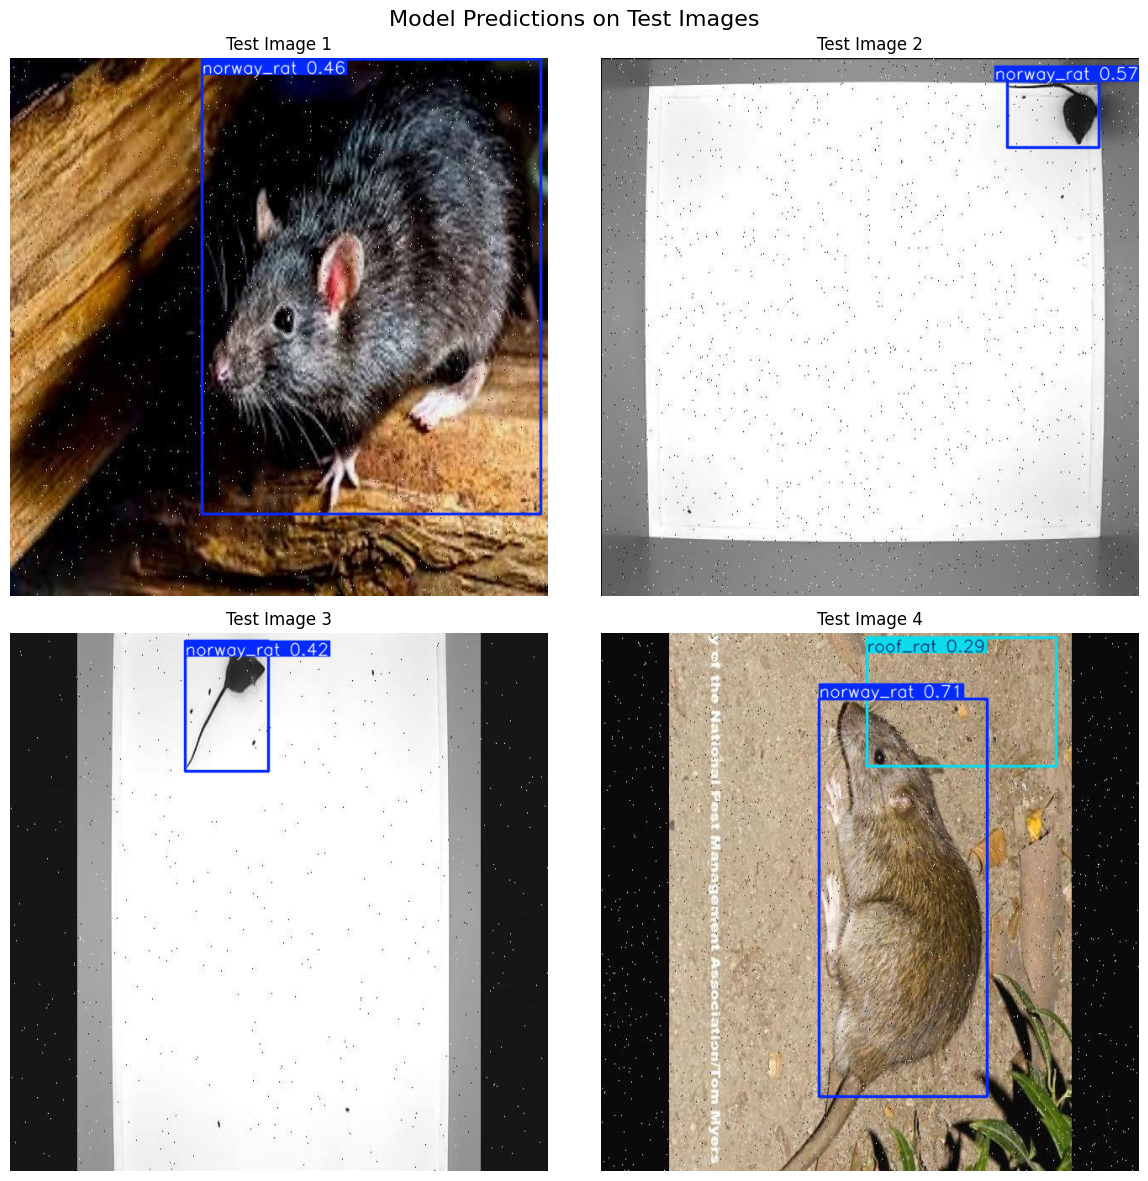

In [ ]:
# Load best model
best_model_path = 'rat_detection/yolov8m_rats/weights/best.pt'
if os.path.exists(best_model_path):
    model = YOLO(best_model_path)
    print("✅ Best model loaded")

# Test on sample images
test_dir = os.path.join(dataset_path, 'test', 'images')
test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')][:4]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, img_file in enumerate(test_images):
    img_path = os.path.join(test_dir, img_file)

    # Run inference
    results = model(img_path, conf=0.25)

    # Plot results
    img_with_predictions = results[0].plot()
    axes[idx].imshow(cv2.cvtColor(img_with_predictions, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f"Test Image {idx + 1}")
    axes[idx].axis('off')

plt.suptitle("Model Predictions on Test Images", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Copy the entire model directory
!cp -r /content/rat_detection/yolov8m_rats /content/drive/MyDrive/zakaria/Rodent_ai_vision/
print("✅ Full model directory copied successfully")

# Verify the copy
!ls -la /content/drive/MyDrive/zakaria/Rodent_ai_vision/yolov8m_rats/weights/
print("\n📁 Model weights available:")
print("  - best.pt (52MB) - Use this for deployment")
print("  - last.pt (52MB) - Final epoch weights")

✅ Full model directory copied successfully
total 101660
-rw------- 1 root root 52049874 Sep 18 13:51 best.pt
-rw------- 1 root root 52049874 Sep 18 13:51 last.pt

📁 Model weights available:
  - best.pt (52MB) - Use this for deployment
  - last.pt (52MB) - Final epoch weights


In [ ]:
# Load your trained model
model = YOLO('/content/rat_detection/yolov8m_rats/weights/best.pt')

# Export to ONNX format
print("Exporting model to ONNX format...")
onnx_path = model.export(format='onnx',
                          imgsz=640,
                          simplify=True,
                          opset=12)  # ONNX opset version

print(f"✅ Model exported to: {onnx_path}")

# Copy ONNX model to Google Drive
!cp /content/rat_detection/yolov8m_rats/weights/best.onnx /content/drive/MyDrive/zakaria/Rodent_ai_vision/yolov8m_rats/weights/best.onnx
print("✅ ONNX model saved to Google Drive")

# Verify the ONNX file
!ls -lh /content/drive/MyDrive/zakaria/Rodent_ai_vision/yolov8m_rats/weights/best.onnx

Exporting model to ONNX format...
Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs

PyTorch: starting from '/content/rat_detection/yolov8m_rats/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (49.6 MB)

ONNX: starting export with onnx 1.19.0 opset 12...
ONNX: slimming with onnxslim 0.1.68...
ONNX: export success ✅ 2.6s, saved as '/content/rat_detection/yolov8m_rats/weights/best.onnx' (98.8 MB)

Export complete (3.6s)
Results saved to /content/rat_detection/yolov8m_rats/weights
Predict:         yolo predict task=detect model=/content/rat_detection/yolov8m_rats/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/content/rat_detection/yolov8m_rats/weights/best.onnx imgsz=640 data=/content/dataset/data.yaml  
Visualize:       https://netron.app
✅ Model exported to: /content/rat_detection/yolov8m_rats/weights/b

## Summary

In [ ]:
print("=" * 60)
print("TRAINING COMPLETE - MODEL READY FOR DEPLOYMENT")
print("=" * 60)

print("✅ Completed:")
print("  • Model trained on 2,109 rat images")
print("  • Can detect Norway Rats and Roof Rats")
print("  • Model saved to Google Drive")
print("  • Ready for Twilio integration")

if metrics:
    print(f"📊 Performance:")
    print(f"  • mAP@0.5: {metrics.box.map50:.2%}")
    print(f"  • Precision: {metrics.box.mp:.2%}")
    print(f"  • Recall: {metrics.box.mr:.2%}")

print("🚀 Next Steps:")
print("  1. Download the model (rat_detection_model.zip)")
print("  2. Integrate with your detection system")
print("  3. Set up Twilio alerts")
print("  4. Deploy for real-time monitoring")

print("Good luck with your rat detection system! 🐀")